# Outlier detection

This project sets out to showcase how outlier detection can be done on a dataset, specifically here who are overcharged for insurance. Once detected, outliers can be investigated further, which we do not do here, we simply detect them.

## Dataset

About this Dataset

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance



In this project we will do some outlier detection. It is the process of identifying data points that significantly deviate from the rest of the dataset. These points may indicate:

Errors (e.g., data entry mistakes)

Rare events (e.g., fraud, failures, or discoveries)

Legitimate but unusual behavior



In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r'C:\Users\Gaming\Downloads\insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We will review four different domains of outlier detection.

- Visualization
- Statistical method
- Distance based method
- Model based method

## Visualization

C:\Users\Gaming\AppData\Local\Temp\ipykernel_17796\673610980.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='smoker', y='charges', order=['yes', 'no'], palette="Set2")


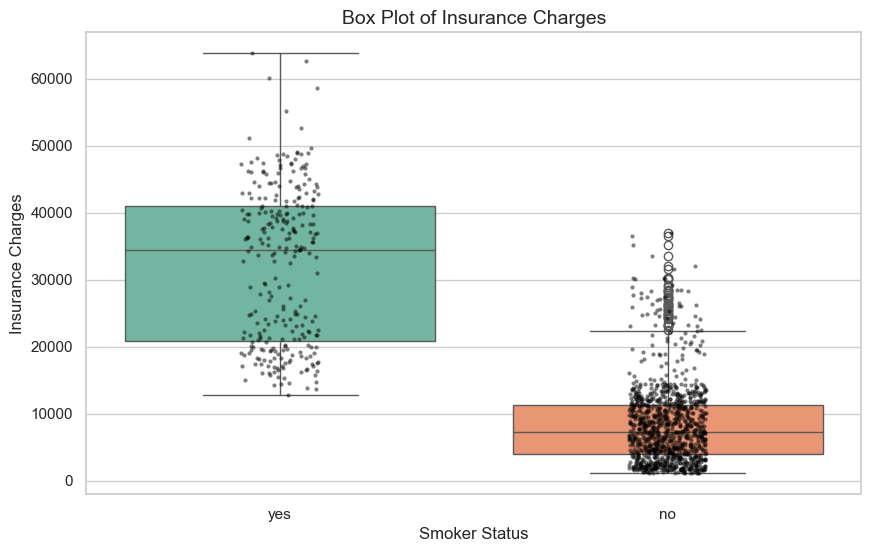

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for aesthetics
sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='smoker', y='charges', order=['yes', 'no'], palette="Set2")
sns.stripplot(data=df, x='smoker', y='charges', order=['yes', 'no'],
              jitter=True, color='black', alpha=0.5, size=3)

# Set labels and title
ax.set_title('Box Plot of Insurance Charges', fontsize=14)
ax.set_xlabel('Smoker Status')
ax.set_ylabel('Insurance Charges')

plt.show()

The boxes in the box plots show the middle 50 per cent of the data. The bottom and top of the box show 25th and 75th percentiles. The whiskers show the quartiles plus and minus 1.5 * interquartile range and is designed to include observations that are not outliers. So while we have 4-7 insurance chargers for smokers that are a bit higher than the others the box plot would suggest these are not outliers. For non-smokers however, quite a number of insurance chargers exceed the top whisker suggesting these are outliers.

## Statistical method

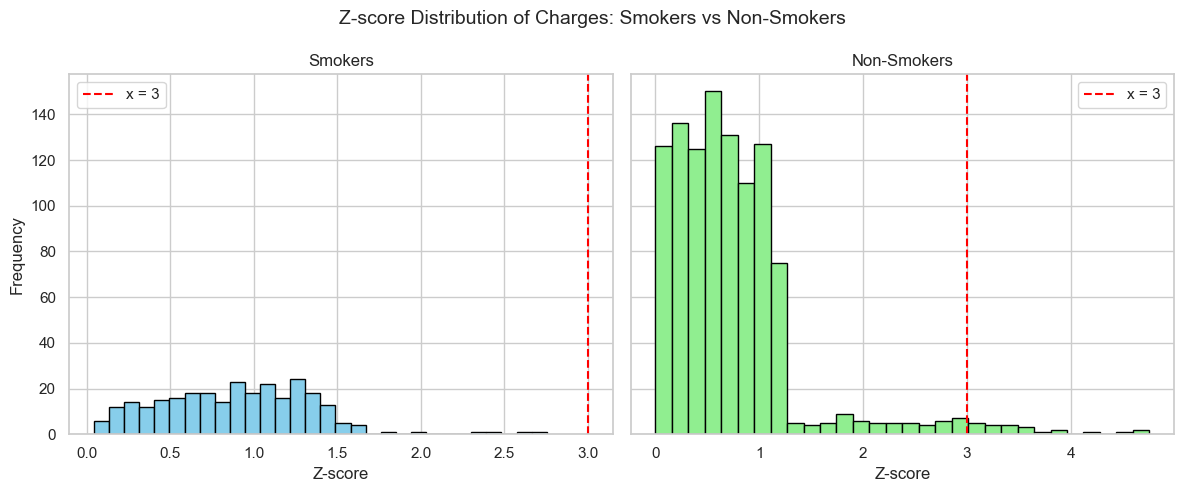

In [5]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Assume df is your DataFrame with numeric columns
df_smokers = df[df['smoker'] == 'yes']
df_nonsmokers = df[df['smoker'] == 'no']
z_scores_smokers = np.abs(zscore(df_smokers['charges']))
z_scores_nonsmokers = np.abs(zscore(df_nonsmokers['charges']))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Smokers
axs[0].hist(z_scores_smokers, bins=30, color='skyblue', edgecolor='black')
axs[0].axvline(x=3, color='red', linestyle='--', label='x = 3')
axs[0].set_title('Smokers')
axs[0].set_xlabel('Z-score')
axs[0].set_ylabel('Frequency')
axs[0].legend()
axs[0].grid(True)

# Non-smokers
axs[1].hist(z_scores_nonsmokers, bins=30, color='lightgreen', edgecolor='black')
axs[1].axvline(x=3, color='red', linestyle='--', label='x = 3')
axs[1].set_title('Non-Smokers')
axs[1].set_xlabel('Z-score')
axs[1].legend()
axs[1].grid(True)

# Overall layout
plt.suptitle('Z-score Distribution of Charges: Smokers vs Non-Smokers', fontsize=14)
plt.tight_layout()
plt.show()


Above we plot the z-score distribution of insurance charges for smokers and non-smokers. 
The red dashed line at x = 3 indicates the threshold for identifying outliers based on the z-score. 
This analysis helps in understanding how the charges deviate from the mean for both groups, highlighting potential outliers in the dataset.

In [6]:
print(f"Number of smokers: {len(z_scores_smokers)} and non-smokers: {len(z_scores_nonsmokers)}")

Number of smokers: 274 and non-smokers: 1064


In [7]:
print(f"Number of outlier smokers: {len(z_scores_smokers[z_scores_smokers > 3])} and outlier non-smokers: {len(z_scores_nonsmokers[z_scores_nonsmokers > 3])}")
print(f"Percentage of outlier smokers: {len(z_scores_smokers[z_scores_smokers > 3]) / len(z_scores_smokers) * 100:.2f}%")
print(f"Percentage of outlier non-smokers: {len(z_scores_nonsmokers[z_scores_nonsmokers > 3]) / len(z_scores_nonsmokers) * 100:.2f}%")

Number of outlier smokers: 0 and outlier non-smokers: 24
Percentage of outlier smokers: 0.00%
Percentage of outlier non-smokers: 2.26%


## Distance-Based Methods

Let's use a K nearest neighbor (KNN) regression model to check for outliers.
KNN regression predicts the target value based on the average of nearby neighbors (in feature space).

If a data point’s actual target value is very different from its KNN-predicted value, it means it doesn’t “fit” well with its neighbors.

This large prediction error (residual) can signal that the point is an outlier — it behaves differently than similar points.

The beauty of this distance based model is that it is intuitive and it uses the full feature space, not only whether the client is smoker or not.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix


# 1. Split features and target
X = df.drop('charges', axis=1)
y = df['charges']

categorical_cols = ['sex', 'smoker', 'region']
numeric_cols = X.drop(columns=categorical_cols).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)  # drop='first' to avoid dummy trap
])

# Build pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)


When the model is fitted on training data, we can use it to predict it on the test data (20 per cent of the data set) to see how the data points converge.

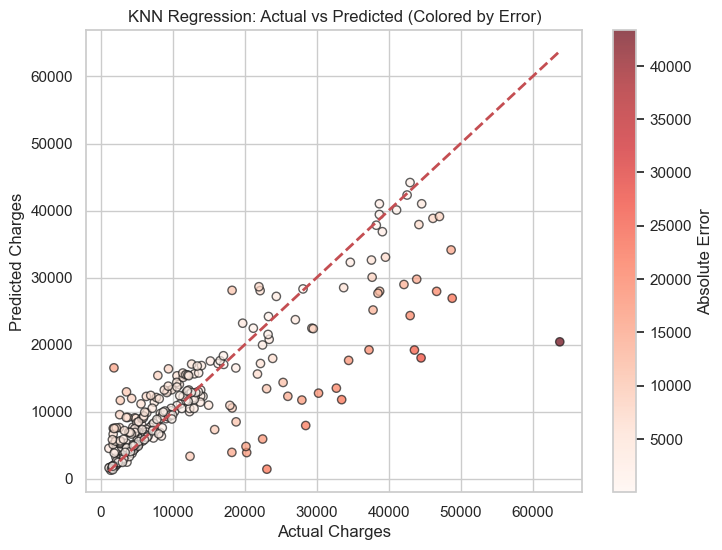

In [11]:
import numpy as np

# Compute residuals
residuals = np.abs(y_test - y_pred)

# Create scatter plot with colormap based on residuals
plt.figure(figsize=(8, 6))
sc = plt.scatter(y_test, y_pred, c=residuals, cmap='Reds', alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # y = x line

# Add color bar to show the scale of the residuals
cbar = plt.colorbar(sc)
cbar.set_label('Absolute Error')

# Labels and title
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('KNN Regression: Actual vs Predicted (Colored by Error)')
plt.grid(True)
plt.show()


The observations are colored according to the error (actual-predicted), the larger error the more redis the color.
It seems that there in the test data set is at least one outlier where the actual charge for the client was around 65,000 while the model predicted it to be around 20,000. 

We can check how the residuals between the actual test data and the predictions form around zero and choose a threshold to define outliers. Let's say that a difference of 20,000 is an outlier.

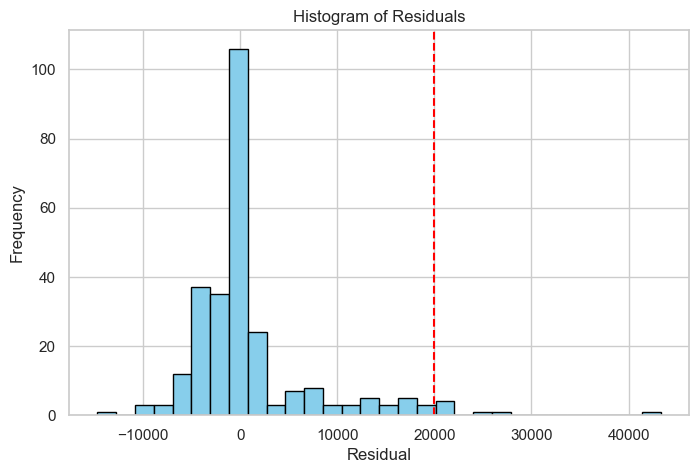

In [12]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=20_000, color='red', linestyle='--', label='x = 3')

plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [13]:
print(f"Number of outliers in the test data set: {len(residuals[residuals > 20_000])}")

Number of outliers in the test data set: 7


## Model-Based Methods

1. Isolation forest

Isolation Forest is an efficient and effective algorithm for anomaly detection that works by isolating observations in the data. Instead of profiling normal data points, it explicitly isolates anomalies by randomly selecting features and splitting values to create partitions. Because outliers are few and different, they tend to be isolated quickly with fewer splits compared to normal points, which require more partitions to be isolated. This property allows the algorithm to assign an anomaly score based on how easily a data point can be separated from the rest. Isolation Forest is particularly well-suited for high-dimensional datasets and large volumes of data due to its low computational cost and scalability. Its ability to detect anomalies without making strong assumptions about the underlying data distribution makes it a popular choice for unsupervised outlier detection tasks.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols = ['sex', 'smoker', 'region']
numeric_cols = X.drop(columns=categorical_cols).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

X_processed = preprocessor.fit_transform(X)

In [15]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% expected outliers
iso_forest.fit(X_processed)

# Predict: -1 for outliers, 1 for inliers
outliers_iso = iso_forest.predict(X_processed)


2. Support Vector Machine

One-Class Support Vector Machine (One-Class SVM) is an unsupervised learning algorithm used for anomaly detection that models the boundary around normal data points in the feature space. It works by finding a function that captures the region where most of the training data lies, effectively separating the normal instances from the origin in a transformed high-dimensional space using kernel functions. Data points that fall outside this learned boundary are considered anomalies or outliers. One-Class SVM is especially useful when the majority of the data is normal and anomalies are rare and distinct. The method is sensitive to the choice of kernel and hyperparameters, which control the shape and tightness of the boundary. It performs well in low- to medium-dimensional datasets but can be computationally intensive with very large or high-dimensional data.










In [16]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)  # nu ~ expected outliers fraction
ocsvm.fit(X_processed)

outliers_ocsvm = ocsvm.predict(X_processed)  # -1 for outliers, 1 for inliers


OK, so both models are fitted to the data. we can check both models count of outliers. so there are 1,229 observations that are not counted as outliers by either model and 33 observations that are categorized as outliers by both models.

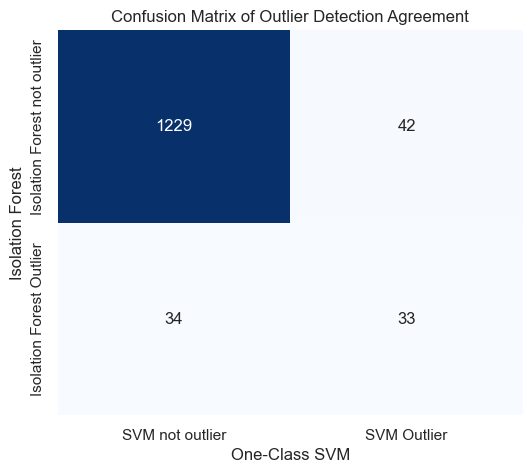

In [17]:
df['outlier_iso'] = (outliers_iso == -1)
df['outlier_ocsvm'] = (outliers_ocsvm == -1)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df['outlier_iso'] and df['outlier_ocsvm'] are boolean: True=outlier, False=inlier
y_true = df['outlier_iso'].astype(int)      # Convert True/False to 1/0
y_pred = df['outlier_ocsvm'].astype(int)

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['SVM not outlier', 'SVM Outlier'],
            yticklabels=['Isolation Forest not outlier', 'Isolation Forest Outlier'])
plt.xlabel('One-Class SVM')
plt.ylabel('Isolation Forest')
plt.title('Confusion Matrix of Outlier Detection Agreement')
plt.show()

Let's check how the outliers are formed in either model as compared to all features by truncating these into two principal components.

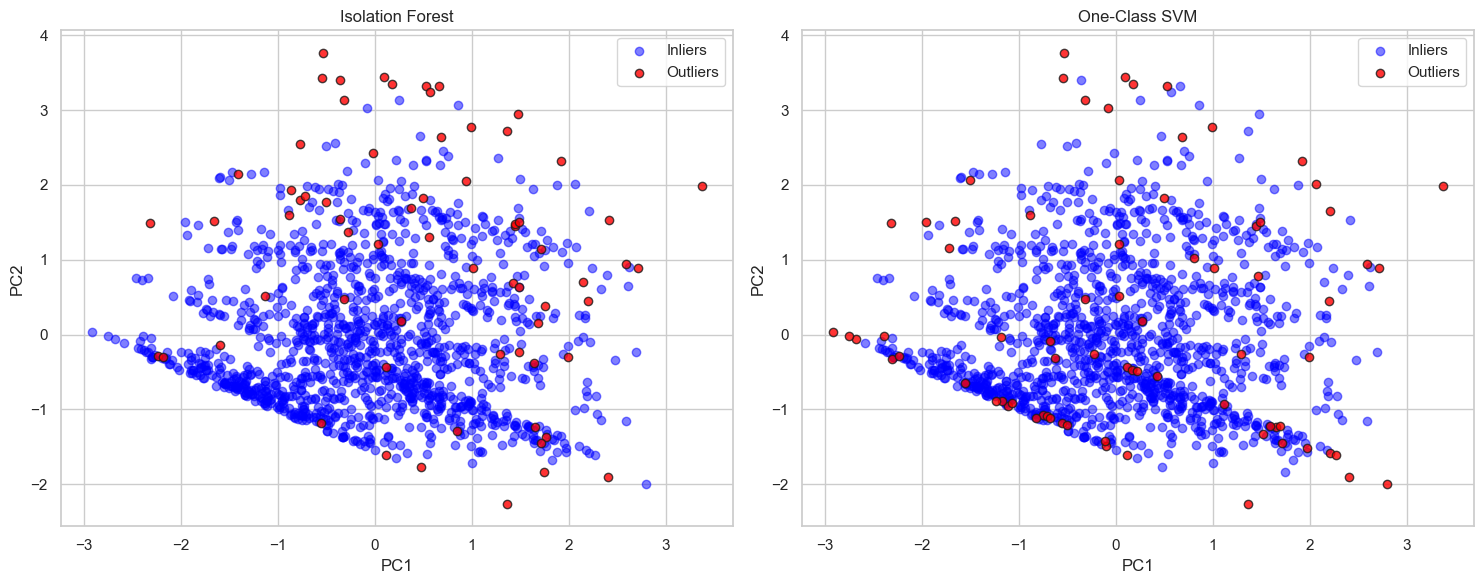

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA to reduce features to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

def scatter_outliers(ax, X_2d, outliers, title):
    ax.scatter(X_2d[outliers == 1, 0], X_2d[outliers == 1, 1],
               c='blue', label='Inliers', alpha=0.5)
    ax.scatter(X_2d[outliers == -1, 0], X_2d[outliers == -1, 1],
               c='red', label='Outliers', alpha=0.8, edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend()
    ax.grid(True)

scatter_outliers(axes[0], X_pca, outliers_iso, 'Isolation Forest')
scatter_outliers(axes[1], X_pca, outliers_ocsvm, 'One-Class SVM')

plt.tight_layout()
plt.show()

Let's narrow down the observations that are categorized as outliers by both models. Overlapping outliers show where both models detect anomalies, strengthening confidence in those points.

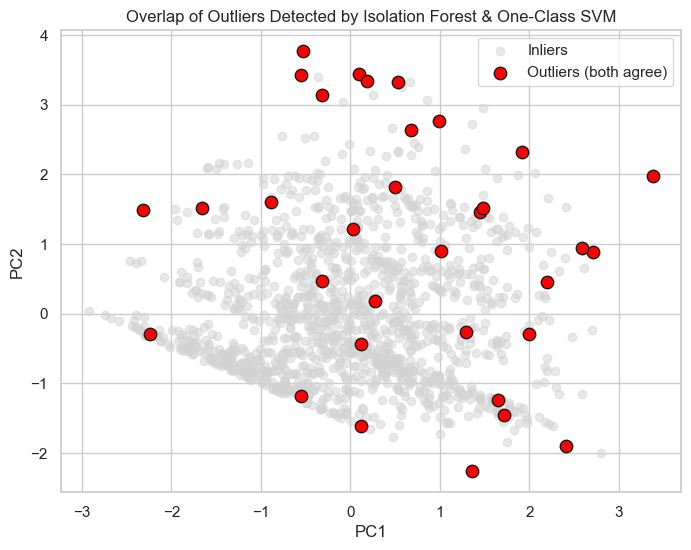

In [20]:
overlap = (outliers_iso == -1) & (outliers_ocsvm == -1)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgray', label='Inliers', alpha=0.5)

# Plot points where both agree on outlier
plt.scatter(X_pca[overlap, 0], X_pca[overlap, 1], 
            c='red', label='Outliers (both agree)', edgecolors='k', s=80)

plt.title('Overlap of Outliers Detected by Isolation Forest & One-Class SVM')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

So it appears the outliers are not neatly cluster at the edges or extremes of the PC1-PC2 scatter plot. There may be a few reasons for this.

Isolation Forest and One-Class SVM operate in the full feature space (all numeric + encoded categorical features). PCA plot shows a compressed 2D view, which loses some information.

PCA preserves variance but not necessarily outlierness. PCA finds directions (principal components) that maximize variance in the data. Outliers might not lie along directions of maximum variance — they could be anomalies in more subtle feature combinations.

Outliers may differ in complex, high-dimensional ways. Outliers could be unusual in feature combinations that aren’t captured well by just the first two PCs. So, projecting down to 2D can “mix” them spatially.

Let's try as a last point UMAP (Uniform Manifold Approximation and Projection) which is a powerful nonlinear dimensionality reduction technique designed for visualizing high-dimensional data in lower dimensions, typically 2D or 3D. It works by modeling the data as a fuzzy topological structure (a weighted graph) and then optimizes a low-dimensional embedding that preserves both local neighbor relations and the global data structure as faithfully as possible and it also accounts for possible non-linearities in the data that is not accounted for using principal components. UMAP’s embedding is optimized to keep similar points close and dissimilar points apart in a nonlinear way, so clusters tend to be tighter, and outliers more isolated visually

c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


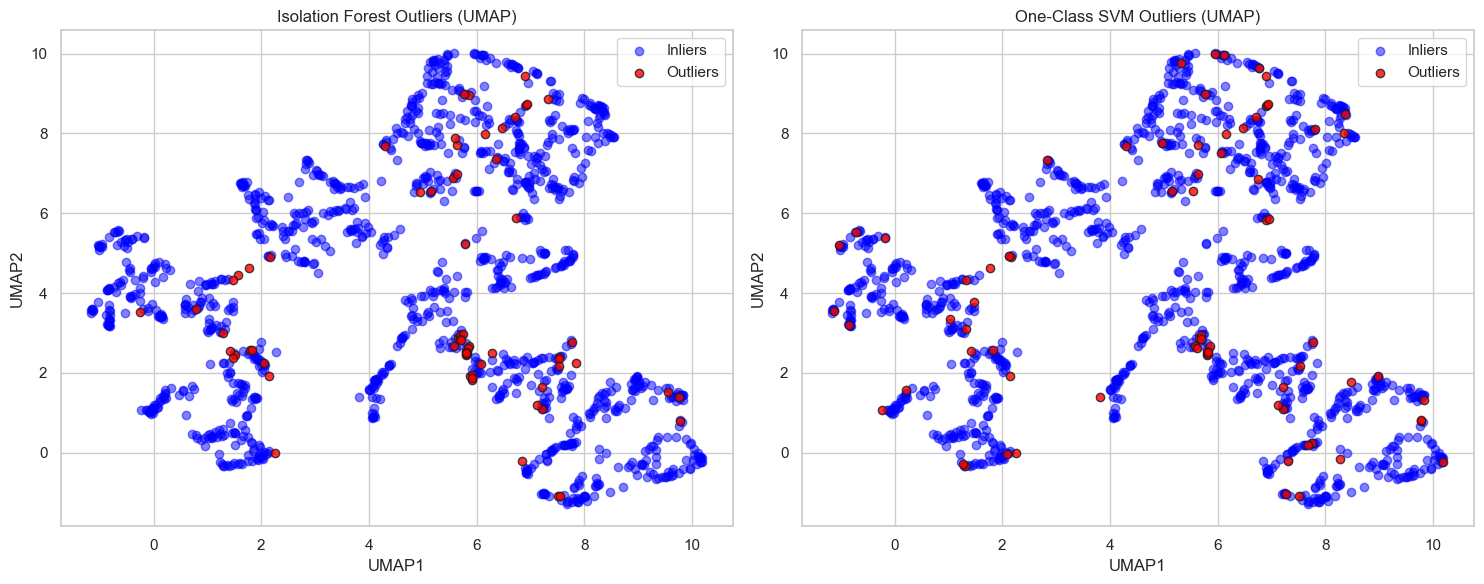

In [21]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Fit UMAP to reduce dimensions to 2D
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_processed)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

def scatter_outliers(ax, X_embedded, outliers, title):
    ax.scatter(X_embedded[outliers == 1, 0], X_embedded[outliers == 1, 1],
               c='blue', label='Inliers', alpha=0.5)
    ax.scatter(X_embedded[outliers == -1, 0], X_embedded[outliers == -1, 1],
               c='red', label='Outliers', alpha=0.8, edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.legend()
    ax.grid(True)

scatter_outliers(axes[0], X_umap, outliers_iso, 'Isolation Forest Outliers (UMAP)')
scatter_outliers(axes[1], X_umap, outliers_ocsvm, 'One-Class SVM Outliers (UMAP)')

plt.tight_layout()
plt.show()


So some of the outliers appear to lie in more sparse regions of the UMAP feature space, suggesting that here they are further away from denser clusters. These points are somewhat expected as outliers since they lie in low-density areas between the main clusters — likely representing rare or unusual combinations of features. They may correspond to borderline cases or transition points that don’t clearly belong to any single cluster.

The observations towards the top for example that are more clearly in a cluster could suggest subtle anomalies where slight deviations in feature values make them stand out statistically but not enough to separate visually.

The outlier detection models also capture different types of anomalies. Those in low-density regions (global anomalies) versus those embedded in clusters but statistically unusual (local anomalies). This suggests a rich, nuanced structure in the data —some anomalies are obvious “stragglers,” others are “hidden” in clusters. The UMAP has a couple of hyperparameters that can be tuned, let's try it out.



c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 over

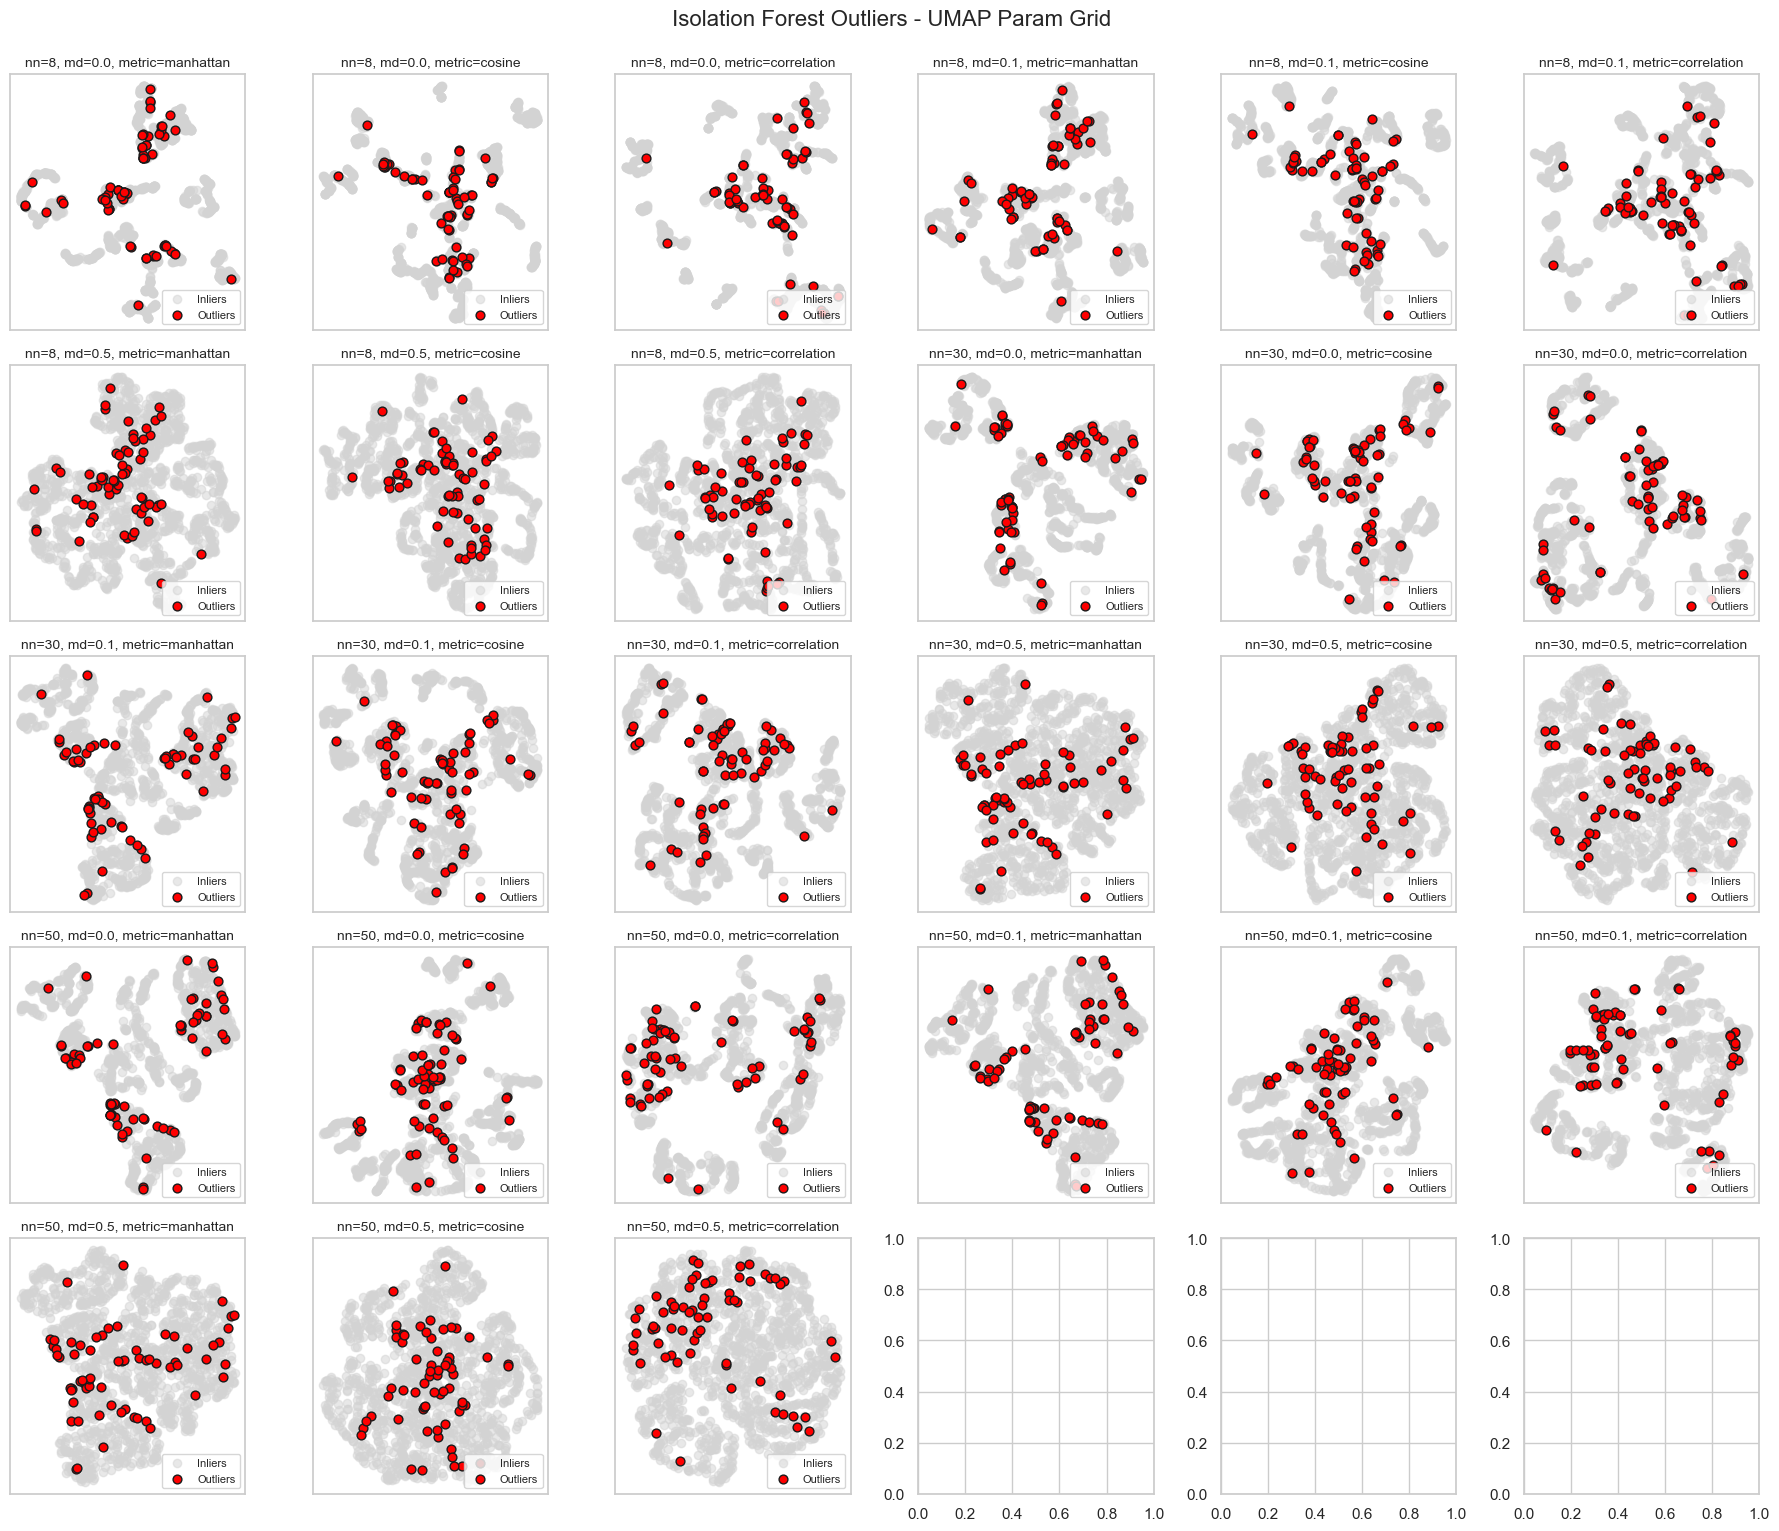

In [27]:
#hyperparameter tuning for UMAP
from itertools import product
param_grid = {
    'n_neighbors': [8, 30, 50],
    'min_dist': [0.0, 0.1, 0.5],
    'metric': ['manhattan', 'cosine', 'correlation']
}

# Prepare all parameter combinations (9 total)
param_combinations = list(product(param_grid['n_neighbors'], param_grid['min_dist'], param_grid['metric']))

# Set up 3x3 plot grid
fig, axes = plt.subplots(5, 6, figsize=(18, 15))
axes = axes.flatten()

for i, (n_neighbors, min_dist, metric) in enumerate(param_combinations):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        n_components=2,
        random_state=42
    )
    X_umap = reducer.fit_transform(X_processed)

    ax = axes[i]
    ax.scatter(X_umap[outliers_iso == 1, 0], X_umap[outliers_iso == 1, 1],
               c='lightgray', alpha=0.5, label='Inliers')
    ax.scatter(X_umap[outliers_iso == -1, 0], X_umap[outliers_iso == -1, 1],
               c='red', edgecolors='k', label='Outliers', s=40)
    ax.set_title(f'nn={n_neighbors}, md={min_dist}, metric={metric}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.suptitle('Isolation Forest Outliers - UMAP Param Grid', fontsize=16, y=1.02)
plt.show()


OK, so it is not immediately clear which hyperparameter combination in UMAP that performed the best in distinguishing outliers. Perhaps the 50 neighbors, minimum distance of 0.1 and manhattan or alternatively 50 neighbors, minimum distance of 0 and correlation metric could be contenders but it is hard to tell. Let's calculate some metrics that can tell us, but in any case UMAP seems not to have performed that well overall. 

In [28]:
from sklearn.metrics import silhouette_score
scores = []

for (n_neighbors, min_dist, metric) in param_combinations:
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=42)
    X_umap = reducer.fit_transform(X_processed)
    
    inliers = X_umap[outliers_iso == 1]
    outliers = X_umap[outliers_iso == -1]
    
    # Silhouette Score
    labels = np.where(outliers_iso == -1, 1, 0)
    sil_score = silhouette_score(X_umap, labels)
    
    # Centroid distance
    centroid_dist = np.linalg.norm(inliers.mean(axis=0) - outliers.mean(axis=0))
    
    scores.append({
        'n_neighbors': n_neighbors,
        'min_dist': min_dist,
        'metric': metric,
        'silhouette': sil_score,
        'centroid_dist': centroid_dist
    })

# Sort results
import pandas as pd
results_df = pd.DataFrame(scores)
results_df = results_df.sort_values(by='silhouette', ascending=False)
print(results_df)


c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Gaming\miniconda3\envs\ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 over

    n_neighbors  min_dist       metric  silhouette  centroid_dist
26           50       0.5  correlation    0.001610       1.824844
20           50       0.0  correlation   -0.022172       1.297640
18           50       0.0    manhattan   -0.031759       0.457697
23           50       0.1  correlation   -0.033438       0.832600
21           50       0.1    manhattan   -0.041948       0.476464
24           50       0.5    manhattan   -0.059388       0.696134
12           30       0.1    manhattan   -0.062169       0.450306
11           30       0.0  correlation   -0.065186       0.636116
9            30       0.0    manhattan   -0.065329       0.298584
15           30       0.5    manhattan   -0.077722       0.838166
17           30       0.5  correlation   -0.089442       0.987479
14           30       0.1  correlation   -0.099126       0.891662
16           30       0.5       cosine   -0.103591       1.226335
0             8       0.0    manhattan   -0.105671       1.042455
3         

The silhouette score measures how well a data point fits within its assigned group compared to other groups. It ranges from -1 to 1, where higher values indicate better-defined, well-separated clusters. In the context of outlier detection, it quantifies how clearly outliers and inliers form distinct groups in the embedding space.

Centroid distance is the Euclidean distance between the mean positions (centroids) of two groups—in this case, inliers and outliers—in the reduced (e.g., UMAP) space. A larger centroid distance suggests the groups are more spatially separated. It gives a direct measure of physical separation in the 2D layout.

So it seems that the models with a larger number of neighbor points and manhattan and correlation metrics performed the best. 

A large n_neighbors (like 50) means UMAP was better at capturing broader, global relationships between data points. This implies your dataset has meaningful structure at a large scale—outliers are distinguishable not just locally but in how they deviate from the global pattern.

The metrics suggest that the data features have meaningful patterns or ranks, and absolute magnitudes may not be as important.

Since large neighborhoods and global-aware metrics worked best, it implies outliers are consistently more different from the bulk of the data in a global context — not just locally noisy. 

Although, as it seems different to pin down a consistent set of outliers across models or even in UMAP alone to distinguish them clearly from the bulk of the data, it suggests that finding outliers depends on what variables factor into such a decision, and the definition of "outlier" itself may vary depending on the context or application. This variability highlights the importance of domain knowledge and careful feature selection, as different aspects of the data might reveal different kinds of anomalies. Ultimately, combining multiple methods and perspectives often leads to more robust and meaningful outlier detection.
